# Lessons Learnt

There are two visual tests for normality: 
* Histogram of random variable plot against a normal denisty function
* (QQ) plots where sample quantile values are compared to theoretical qunatile values. 
However, there are more rigorous statistical tests:
* Skewness test
* Kurtosis test
* Normality test

If the p-value of these tests are 0.05 or above, then the null hypothesis (normality) cannot be rejected. 

For the stock market returns and other asset classes, such as geometric brownian motion model, the normal assumptions cannot be justified in general. It may be necessary to use richer models that are able to generate fat tailes (e.g, jump diffusion models or models with stochastic volatility)


In [74]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt
import pandas_datareader as pdr
import datetime as dt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

The level of stock index $S_T$ at a future date $T$ given a level $S_0$ as of today is given according to the following equation: 

$
S_T = S_0 \exp((r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}z)
$

where,

$S_T$ is the index level at date T

$r$ is a constant riskless short rate

$\sigma$ is te constant volatility (standard deviation of returns) of $S$

$z$ is the standard normally distributed random variable 


In [3]:
S0 = 100 # stock level as of today
r = 0.05 # constant riskless short rate
sigma = 0.25 # constant volatility
T = 2 # future date / horizon in year fractions
I = 10000 # Number of simulations

ST1 = S0 * np.exp((r - 0.5 * sigma **2) * T + sigma * math.sqrt(T) * np.random.standard_normal(I))

Text(0, 0.5, 'frequency')

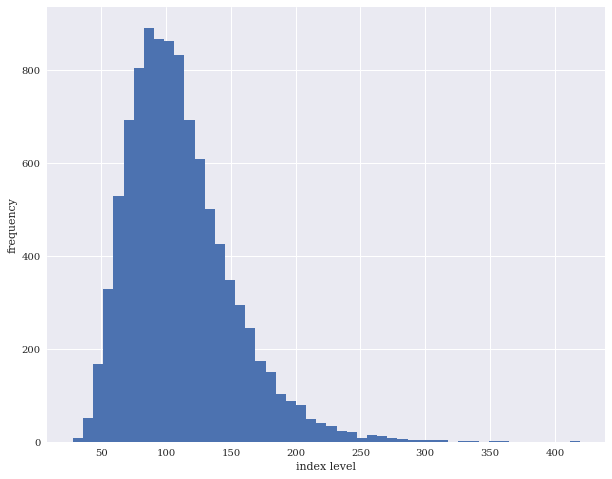

In [4]:
plt.figure(figsize = (10,8))
plt.hist(ST1, bins = 50)
plt.xlabel('index level')
plt.ylabel('frequency')

In [5]:
def gen_paths(S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion
    
        Parameters
        ==========
        
        S0: float - initial stock/index value
        r: float - constant short rate 
        sigma: float - constant volatility
        T: float - final time horizon
        M: int - number of time steps/intervals
        I: int - number of paths to be simulated
        
        Returns 
        =======
        paths: ndarray, shape (M+1, I) - simulated paths given the parameters '''

    dt = T / M
    paths = np.zeros((M+1, I))
    paths[0] = S0
    for t in range(1, M+1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * rand) 
    return paths 


In [6]:
S0 = 100
r = 0.05
sigma = 0.2
T = 1
M = 50
I = 250000
np.random.seed(1000)
paths = gen_paths(S0, r, sigma, T, M, I)
S0 * math.exp(r * T)

105.12710963760242

Text(0, 0.5, 'index level')

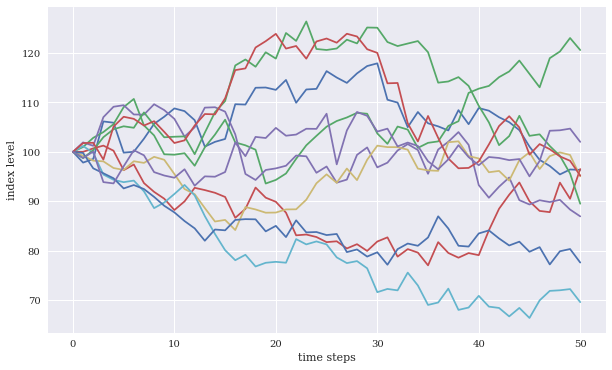

In [7]:
plt.figure(figsize = (10,6))
plt.plot(paths[:, :10])
plt.xlabel('time steps')
plt.ylabel('index level')

In [8]:
log_returns = np.log(paths[1:]/paths[:-1])

In [9]:
def print_statistics(array):
    ''' Prints selected statistics.
        Parameters
        ==========
        array: ndarray - object to generate statistics on '''

    sta = scs.describe(array)
    print("%14s %15s" %('statistic', 'value'))
    print(30 * '-')
    print("%14s %15.5f" %('size', sta[0]))
    print("%14s %15.5f" %('min', sta[1][0]))
    print("%14s %15.5f" %('max', sta[1][1]))
    print("%14s %15.5f" %('mean', sta[2]))
    print("%14s %15.5f" %('std', np.sqrt(sta[3])))
    print("%14s %15.5f" %('skew', sta[4]))
    print("%14s %15.5f" %('kurtosis', sta[5]))



In [10]:
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


-0.17215534612994926 0.16922379995654868


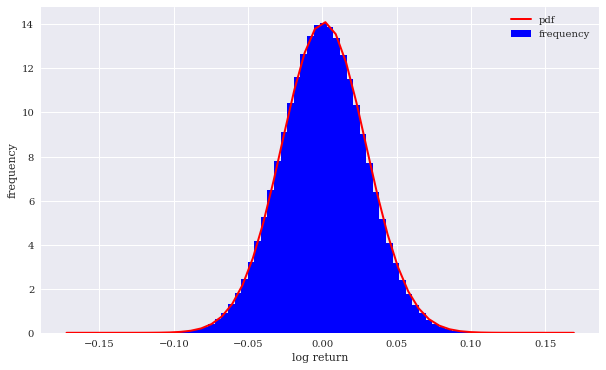

In [14]:
plt.figure(figsize = (10,6))
plt.hist(log_returns.flatten(),bins = 70, density = True, label = 'frequency', color = 'b')
plt.xlabel('log return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc = r/M, scale = sigma/np.sqrt(M)), 'r', lw = 2.0, label = 'pdf')
plt.legend()

Text(0, 0.5, 'sample quantiles')

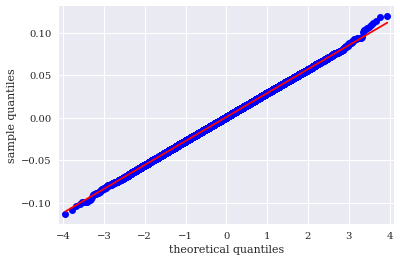

In [15]:
sm.qqplot(log_returns.flatten()[::500], line = 's')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

In [44]:
def normality_tests(arr):
    ''' Tests for normality distribution of given data set. 
        Parameters
        ==========
        array: ndarray to generate statistics on'''
    
    print('Skew of data set %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])

In [45]:
normality_tests(log_returns.flatten())

Skew of data set          0.001
Skew test p-value          0.430
Kurt of data set          0.001
Kurt test p-value          0.541
Norm test p-value          0.607


Text(0.5, 1.0, 'log data')

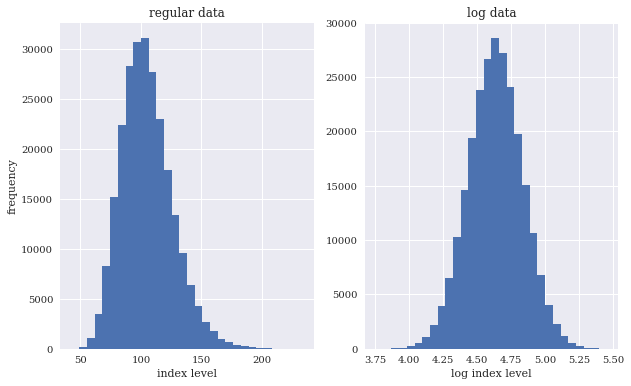

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.hist(paths[-1], bins = 30)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.set_title('regular data')
ax2.hist(np.log(paths[-1]), bins = 30)
ax2.set_xlabel('log index level')
ax2.set_title('log data')

In [55]:
print_statistics(paths[-1])
print("\n")
print_statistics(np.log(paths[-1]))

     statistic           value
------------------------------
          size    250000.00000
           min        42.74870
           max       233.58435
          mean       105.12645
           std        21.23174
          skew         0.61116
      kurtosis         0.65182


     statistic           value
------------------------------
          size    250000.00000
           min         3.75534
           max         5.45354
          mean         4.63517
           std         0.19998
          skew        -0.00092
      kurtosis        -0.00327


In [56]:
normality_tests(np.log(paths[-1]))

Skew of data set         -0.001
Skew test p-value          0.851
Kurt of data set         -0.003
Kurt test p-value          0.744
Norm test p-value          0.931


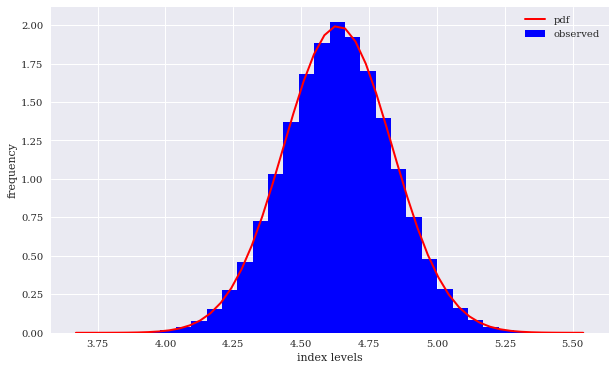

In [67]:
plt.figure(figsize = (10,6))
log_data = np.log(paths[-1])
plt.hist(log_data, bins = 30, density = True, label = 'observed', color = 'b')
plt.ylabel('frequency')
plt.xlabel('index levels')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, log_data.mean(), log_data.std()), 'r', lw = 2.0, label = 'pdf')
plt.legend()

Text(0, 0.5, 'sample quantiles')

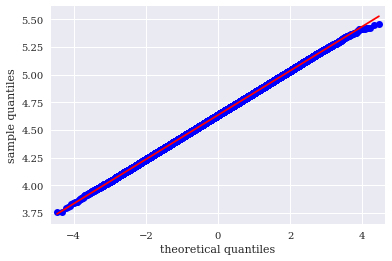

In [68]:
sm.qqplot(log_data, line = 's')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

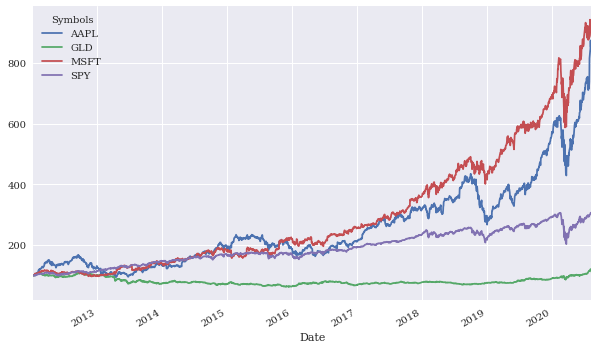

In [84]:
date_start = dt.datetime(2012, 1, 12)
date_end = dt.datetime(2020,8,11)
tickers = ['SPY', 'GLD', 'AAPL','MSFT']
data = pdr.get_data_yahoo(tickers, date_start, date_end)['Adj Close']
(100 * data/data.iloc[0]).plot(figsize = (10,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002101EA80240>,
      dtype=object)

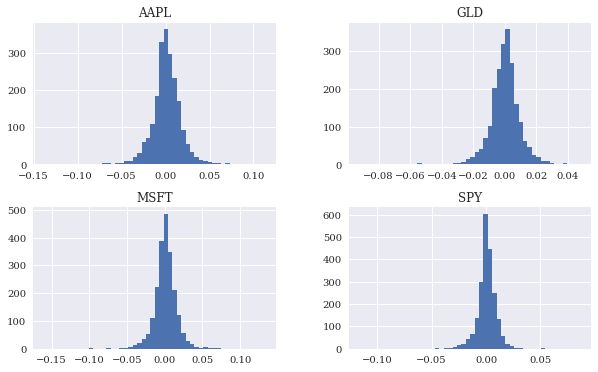

In [86]:
log_returns = (np.log(data)).diff()
log_returns.hist(bins = 50, figsize = (10,6))

In [90]:
for tick in tickers:
    print('\nResults for symbol {}'.format(tick))
    print(30 * '-')
    log_data = np.array(log_returns[tick].dropna())
    print_statistics(log_data)


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2158.00000
           min        -0.11589
           max         0.08673
          mean         0.00052
           std         0.01037
          skew        -1.02857
      kurtosis        20.61771

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2158.00000
           min        -0.09191
           max         0.04787
          mean         0.00005
           std         0.00956
          skew        -0.58226
      kurtosis         7.36722

Results for symbol AAPL
------------------------------
     statistic           value
------------------------------
          size      2158.00000
           min        -0.13771
           max         0.11316
          mean         0.00099
           std         0.01777
          skew        -0.35566
      kurtosis         7.763

Text(0, 0.5, 'sample quantiles')

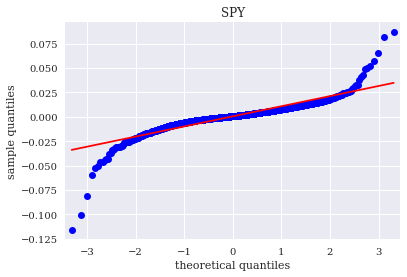

In [92]:
sm.qqplot(log_returns.SPY.dropna(), line = 's')
plt.title('SPY')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

the values that are not aligned with the red line, shows that the SPY log returns shows signs of non-normality. These indicate that he log returns have a fat tail distribution, meaning the there more large negative and large positive values that we would find in a normal distribution. 

In [96]:
for ticker in tickers:
    print('\nResults for symbol {}'.format(ticker))
    print(32 * '-')
    log_data = np.array(log_returns[ticker].dropna())
    normality_tests(log_data)


Results for symbol SPY
--------------------------------
Skew of data set         -1.029
Skew test p-value          0.000
Kurt of data set         20.618
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol GLD
--------------------------------
Skew of data set         -0.582
Skew test p-value          0.000
Kurt of data set          7.367
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol AAPL
--------------------------------
Skew of data set         -0.356
Skew test p-value          0.000
Kurt of data set          7.763
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol MSFT
--------------------------------
Skew of data set         -0.243
Skew test p-value          0.000
Kurt of data set         12.336
Kurt test p-value          0.000
Norm test p-value          0.000
